# Customer Subscription Analysis

In [2]:
#Import libraries
import sqlite3 #for SQLite database connection
import pandas as pd #data manipulation and analysis
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

print('success')

success


In [3]:
#Read in Data
df_cases = pd.read_csv("customer_cases.csv")
df_customer_info = pd.read_csv("customer_info.csv")
df_signup_cancel = pd.read_csv("customer_product.csv")
df_products = pd.read_csv("product_info.csv")

In [ ]:
#Create SQLite database
print("This may take a minute")
conn = sqlite3.connect('subscriptions.db')
cursor = conn.cursor()

df_cases.to_sql('cases', conn, if_exists ='replace', index=False)
df_signup_cancel.to_sql('signup_cancel', conn, if_exists = 'replace', index=False)
df_products.to_sql('products', conn, if_exists ='replace', index=False)
df_customer_info.to_sql('customers', conn, if_exists ='replace', index=False)
print("tables successfully uploaded to SQLite")

In [5]:
#Check table names in the SQL database
tables = cursor.execute("SELECT name FROM sqlite_master WHERE type='table';").fetchall()
print("tables in the database:", tables)
conn.commit()

tables in the database: [('cases',), ('signup_cancel',), ('products',), ('customers',)]


In [6]:
#Check first few rows of each table
for table in ["cases", "signup_cancel", "customers", "products"]:
    query = f"SELECT * FROM {table} LIMIT 5;"
    print(f"First rows of {table}:")
    display(pd.read_sql_query(query, conn))

First rows of cases:


,Unnamed: 0,case_id,date_time,customer_id,channel,reason
0,1,CC101,2017-01-01 10:32:03,C2448,phone,signup
1,2,CC102,2017-01-01 11:35:47,C2449,phone,signup
2,3,CC103,2017-01-01 11:37:09,C2450,phone,signup
3,4,CC104,2017-01-01 13:28:14,C2451,phone,signup
4,5,CC105,2017-01-01 13:52:22,C2452,phone,signup


First rows of signup_cancel:


,Unnamed: 0,customer_id,product,signup_date_time,cancel_date_time
0,1,C2448,prd_1,2017-01-01 10:35:09,None
1,2,C2449,prd_1,2017-01-01 11:39:29,2021-09-05 10:00:02
2,3,C2450,prd_1,2017-01-01 11:42:00,2019-01-13 16:24:55
3,4,C2451,prd_2,2017-01-01 13:32:08,None
4,5,C2452,prd_1,2017-01-01 13:57:30,2021-06-28 18:06:01


First rows of customers:


,Unnamed: 0,customer_id,age,gender
0,1,C2448,76,female
1,2,C2449,61,male
2,3,C2450,58,female
3,4,C2451,62,female
4,5,C2452,71,male


First rows of products:


,product_id,name,price,billing_cycle
0,prd_1,annual_subscription,1200,12
1,prd_2,monthly_subscription,125,1


## 1. Data Preprocessing 
Chcek for missing values

In [8]:
df_cases.isnull().sum()
df_customer_info.isnull().sum()
df_products.isnull().sum()
df_signup_cancel.isnull().sum() #369k missing cancel dates values

Unnamed: 0               0
customer_id              0
product                  0
signup_date_time         0
cancel_date_time    396447
dtype: int64

We can assume the missing cancellation dates indicate the customer has not cancelled their subscription. Lrt's create new column for active and inactive customers. 

In [10]:
df_signup_cancel['status'] = df_signup_cancel['cancel_date_time'].isna().map({True: 'Active', False: 'Inactive'})
df_signup_cancel.head()

,Unnamed: 0,customer_id,product,signup_date_time,cancel_date_time,status
0,1,C2448,prd_1,2017-01-01 10:35:09,NaN,Active
1,2,C2449,prd_1,2017-01-01 11:39:29,2021-09-05 10:00:02,Inactive
2,3,C2450,prd_1,2017-01-01 11:42:00,2019-01-13 16:24:55,Inactive
3,4,C2451,prd_2,2017-01-01 13:32:08,NaN,Active
4,5,C2452,prd_1,2017-01-01 13:57:30,2021-06-28 18:06:01,Inactive


Lets remove the extra column, its unecesaary

In [12]:
# Removes first column
def remove_first_column(df):
    first_column = df.columns[0]
    return df.drop(columns = first_column, axis=1)

df_cases = remove_first_column(df_cases)
df_signup_cancel = remove_first_column(df_signup_cancel)
df_customer_info = remove_first_column(df_customer_info)

Chcek structure and statistics

In [14]:
df_cases.describe()
df_cases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 330512 entries, 0 to 330511
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   case_id      330512 non-null  object
 1   date_time    330512 non-null  object
 2   customer_id  330512 non-null  object
 3   channel      330512 non-null  object
 4   reason       330512 non-null  object
dtypes: object(5)
memory usage: 12.6+ MB


Convert date and time to correct data type

In [16]:
# Converts date column to correct format
date_columns = ['signup_date_time', 'cancel_date_time', 'date_time']

def convert_date_time(df, column_list):
    for column in column_list:
        if column in df.columns:
            df[column] = pd.to_datetime(df[column])
    return df

df_signup_cancel = convert_date_time(df_signup_cancel, date_columns)
df_cases = convert_date_time(df_cases, date_columns)
df_signup_cancel.dtypes

customer_id                 object
product                     object
signup_date_time    datetime64[ns]
cancel_date_time    datetime64[ns]
status                      object
dtype: object

In [17]:
df_cases = df_cases.drop_duplicates()
df_signup_cancel = df_signup_cancel.drop_duplicates()
df_customer_info = df_customer_info.drop_duplicates()
df_products = df_products.drop_duplicates()

### SQL Exploratory Data Analysis

In [19]:
query = '''
    SELECT *
    FROM signup_cancel s
    LEFT JOIN customers c ON c.customer_id = s.customer_id
    WHERE cancel_date_time IS NULL
    ORDER BY c.customer_id
    LIMIT 5
'''
pd.read_sql_query(query, conn)

,Unnamed: 0,customer_id,product,signup_date_time,cancel_date_time,Unnamed: 0,customer_id,age,gender
0,7553,C10000,prd_1,2017-07-09 12:55:31,None,7553,C10000,46,female
1,97553,C100000,prd_2,2021-02-13 11:41:49,None,97553,C100000,54,female
2,97554,C100001,prd_1,2021-02-13 11:45:50,None,97554,C100001,27,female
3,97555,C100002,prd_1,2021-02-13 11:51:02,None,97555,C100002,47,female
4,97556,C100003,prd_1,2021-02-13 11:56:54,None,97556,C100003,63,female


In [20]:
query = '''
    SELECT COUNT(*) AS total_customers
    FROM customers
'''
pd.read_sql_query(query, conn)

,total_customers
0,508932


In [21]:
query = '''
    SELECT COUNT(*) AS cancelled_customers
    FROM signup_cancel
    WHERE cancel_date_time IS NOT NULL
'''
pd.read_sql_query(query, conn)

,cancelled_customers
0,112485


In [22]:
query = '''
    SELECT channel, count(*) AS total_cases
    FROM cases
    GROUP BY channel
'''
pd.read_sql_query(query, conn)

,channel,total_cases
0,email,43672
1,phone,286840


In [23]:
query = '''
    SELECT reason, channel, count(*) AS total_cases
    FROM cases
    GROUP BY reason, channel
'''
pd.read_sql_query(query, conn)

,reason,channel,total_cases
0,signup,phone,129527
1,support,email,43672
2,support,phone,157313


In [24]:
query = '''
    SELECT gender, count(*) AS customers
    FROM customers
    GROUP BY gender
    ORDER BY customers DESC
'''
pd.read_sql_query(query, conn)

,gender,customers
0,male,309930
1,female,199002


In [25]:
query = '''
    SELECT age, count(*) AS customers
    FROM customers
    GROUP BY age
    ORDER BY customers DESC
    LIMIT 5
'''
pd.read_sql_query(query, conn)

,age,customers
0,60,24483
1,61,24380
2,59,24298
3,58,24126
4,62,23645


In [26]:
#Total revenue, total customers, and avg age of 'current' customers
query = '''
    SELECT p.name, avg(c.age) AS avg_age, count(c.customer_id) AS total_customers,
        SUM(p.price) AS total_revenue
    FROM signup_cancel s
    JOIN products p ON s.product = p.product_id
    JOIN customers c ON s.customer_id = c.customer_id
    WHERE s.cancel_date_time IS NOT NULL
    GROUP BY p.name
'''
pd.read_sql_query(query, conn)

,name,avg_age,total_customers,total_revenue
0,annual_subscription,58.470121,69682,83618400
1,monthly_subscription,58.340700,42803,5350375


### Python EDA 

C:\Anaconda_Stuff\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


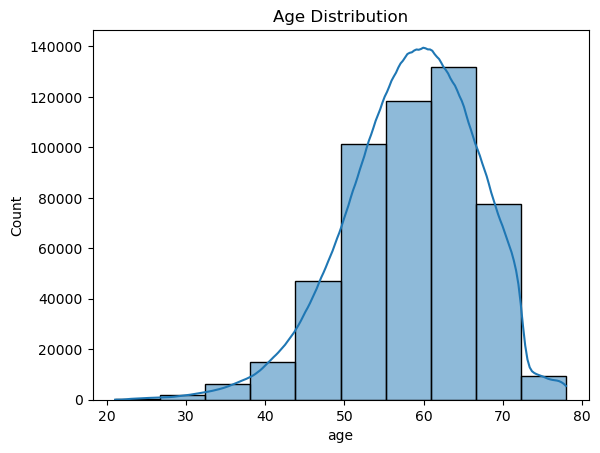

In [28]:
sns.histplot(df_customer_info['age'], bins=10, kde=True)
plt.title('Age Distribution')
plt.show()

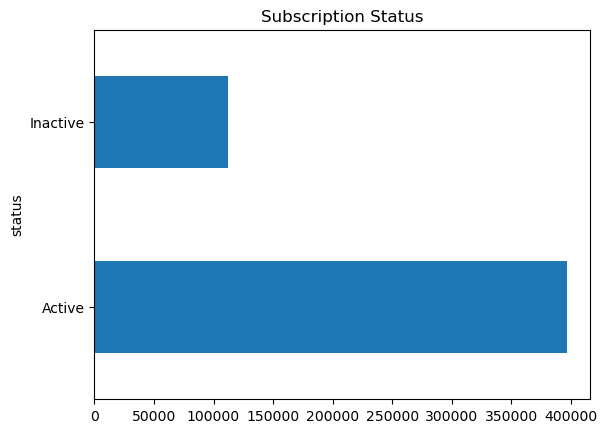

In [29]:
df_signup_cancel['status'].value_counts().plot(kind='barh')
plt.title('Subscription Status')
plt.show()

In [30]:
pivot = df_signup_cancel.pivot_table(
    index='product', columns='status', aggfunc='size', fill_value=0)

print(pivot)

status   Active  Inactive
product                  
prd_1    255967     69682
prd_2    140480     42803


In [31]:
df_signup_cancel[['customer_id', 'status', 'product']].groupby(['product', 'status']).count()

customer_id
product status               
prd_1   Active         255967
        Inactive        69682
prd_2   Active         140480
        Inactive        42803

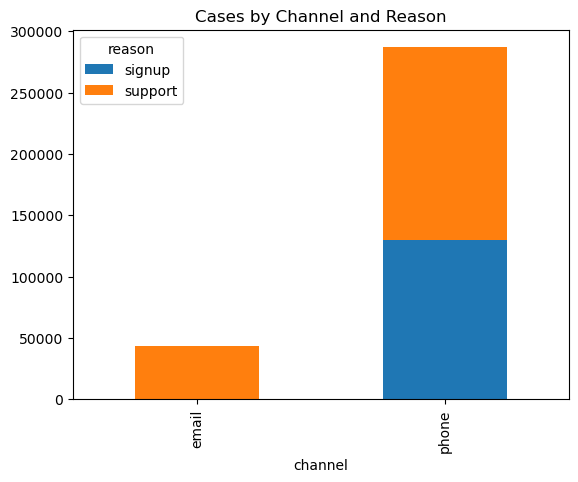

In [32]:
channel_reason = df_cases.groupby(['channel', 'reason']).size().unstack()
channel_reason.plot(kind='bar', stacked=True)
plt.title('Cases by Channel and Reason')
plt.show()

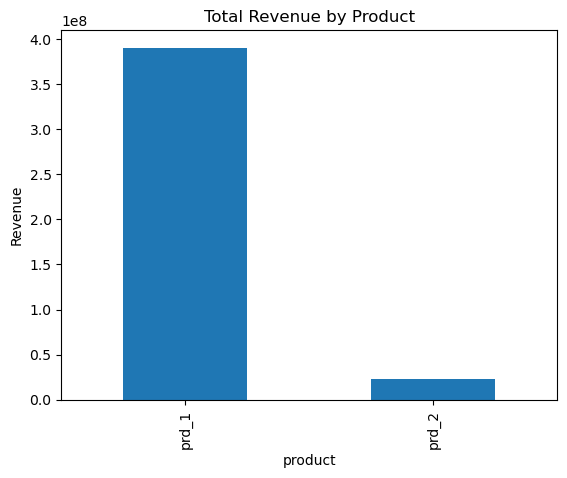

In [33]:
revenue = pd.merge(df_signup_cancel, df_products, left_on='product', right_on='product_id')
revenue['total_revenue'] = revenue['price']

revenue_by_product = revenue.groupby('product')['total_revenue'].sum()
revenue_by_product.plot(kind='bar')
plt.title('Total Revenue by Product')
plt.ylabel('Revenue')
plt.show()

## Times Series Analysis

In [35]:
# df_cases
# df_customer_info
# df_signup_cancel
# df_products

In [36]:
# df_cases.sort_values(by = 'date_time', ascending = False)
# merged_df = pd.merge(df_cases, df_customer_info, on= 'customer_id', how='left')

# merged_df = pd.merge(merged_df, df_signup_cancel, on= 'customer_id', how='left')
# merged_df = pd.merge(merged_df, df_products, left_on='product', right_on= 'product_id')
# merged_df

The main research question is to predict mobthly revenue for the next 6 months. I will use time series analysis to make predictions. 

In [38]:
# Forecast Monthly Revenue
revenue_df = pd.merge(df_signup_cancel, df_products, left_on='product', right_on= 'product_id')
revenue_df['revenue'] = revenue_df['price']

revenue_df['month'] = revenue_df['signup_date_time'].dt.to_period('M') #extract month
revenue_df['month'] = revenue_df['month'].dt.to_timestamp() #convert back to dt
monthly_revenue = revenue_df.groupby('month')[['revenue']].sum()

monthly_revenue.head()

,revenue
month,
2017-01-01,3796100
2017-02-01,3554150
2017-03-01,4017700
2017-04-01,3633750
2017-05-01,3722150


<Axes: title={'center': 'Monthly Revenue'}, xlabel='month'>

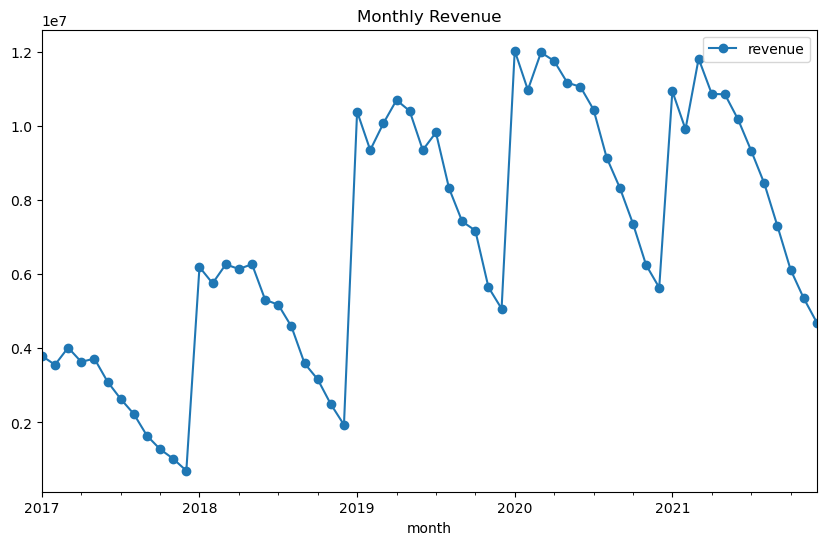

In [39]:
monthly_revenue.plot(title="Monthly Revenue", figsize=(10, 6), marker="o")

We can see there is a clear upward trend. The overall trend is moving upward as time goes on. There is also seasonilty in the data, there appears to be patterns at a fixed interval. Let's now plot the decomposed data.

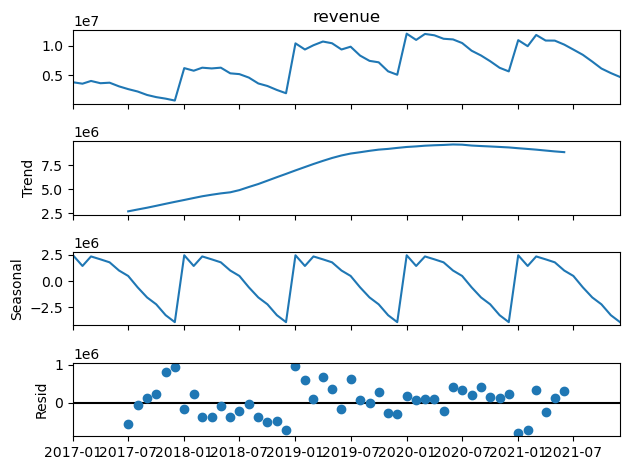

In [41]:
decomposition = seasonal_decompose(monthly_revenue['revenue'], model='additive', period=12)
decomposition.plot()
plt.show()

Clear tren, clear seasonility exist. need to incorportate that using SARIMA. The decomposition confirms the presence of a seasonal component, which means you should proceed with SARIMA (Seasonal ARIMA) to account for seasonality in your forecasting model. The seasonality appears to repeat every 12 months, so the seasonal_period is 12.

#### Check Stationarity

In times-series analysis our data should be stationarity. We can test if out data is staionary using two differing methods, plotting the rolling statistics or the adfuller test. Below i created a function to handle this. 

I'm getting a warning for handling infinity values. To make my code clearer, i will suppress the warnings. 

In [45]:
import warnings

warnings.filterwarnings("ignore")

ADF Statistic: -3.756809229098826,
P-value: 0.003381448015584388
1% -3.5745892596209488
5% -2.9239543084490744
10% -2.6000391840277777
None


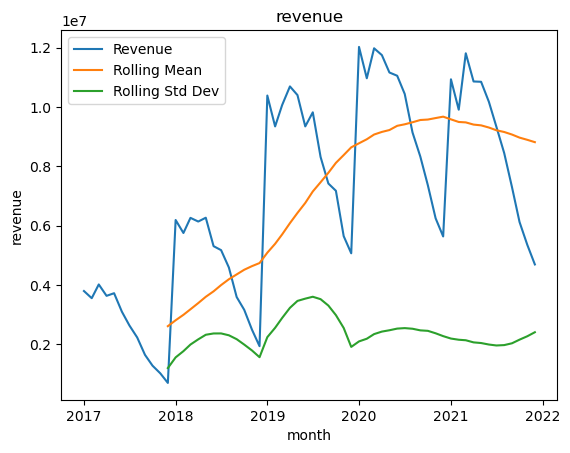

In [46]:
from statsmodels.tsa.stattools import adfuller

def test_stationaity(df, column):
    # df.replace([np.inf, -np.inf], np.nan, inplace=True)
    # df.dropna(subset=[column], inplace=True)
    
    adfuller_test = adfuller(df[column])
    print(f"ADF Statistic: {adfuller_test[0]},\nP-value: {adfuller_test[1]}")

    for k, v in adfuller_test[4].items():
        print(k, v)
        
    df['rolling_mean'] = df[column].rolling(window=12).mean()
    df['rolling_std'] = df[column].rolling(window=12).std()

    sns.lineplot(data=df, x=df.index, y=df[column], label="Revenue")
    sns.lineplot(data=df, x=df.index, y=df['rolling_mean'], label="Rolling Mean")
    sns.lineplot(data=df, x=df.index, y=df['rolling_std'],label="Rolling Std Dev")
    plt.title(column)
    
print(test_stationaity(monthly_revenue, 'revenue'))

The rolling mean and the rolling standard deviation lines are not constant, so this proves our data is not stationary. It shows significant fluctuations and some upward trends. There is a clear trend observed in the roloing mean., smooth curve. the rolling stdev shows variance that is not contanst, suggesgint volatity. The data is clearly non-stationary due to the trends and fluctuations in both the mean and variance.

According to the ADF test, 

In [48]:
monthly_revenue.head(12)

,revenue,rolling_mean,rolling_std
month,,,
2017-01-01,3796100,NaN,NaN
2017-02-01,3554150,NaN,NaN
2017-03-01,4017700,NaN,NaN
2017-04-01,3633750,NaN,NaN
2017-05-01,3722150,NaN,NaN
2017-06-01,3099975,NaN,NaN
2017-07-01,2635100,NaN,NaN
2017-08-01,2230150,NaN,NaN
2017-09-01,1644650,NaN,NaN


#### Transformation

Since our data is not stationary, we must transfrom it until it is stationary. I will use different combinations of difference, log, squared, or cubed root to transform the data. I will reuse my statinoarity function i created above to keep checking if it becomes staionary. 

In [50]:
# monthly_revenue['diff'] = monthly_revenue['revenue'] - monthly_revenue['revenue'].shift()
monthly_revenue['diff'] = monthly_revenue['revenue'].diff()
monthly_revenue.head()

,revenue,rolling_mean,rolling_std,diff
month,,,,
2017-01-01,3796100,NaN,NaN,NaN
2017-02-01,3554150,NaN,NaN,-241950.0
2017-03-01,4017700,NaN,NaN,463550.0
2017-04-01,3633750,NaN,NaN,-383950.0
2017-05-01,3722150,NaN,NaN,88400.0


ADF Statistic: -0.7049132181510707,
P-value: 0.8454727956522775
1% -3.6209175221605827
5% -2.9435394610388332
10% -2.6104002410518627
None


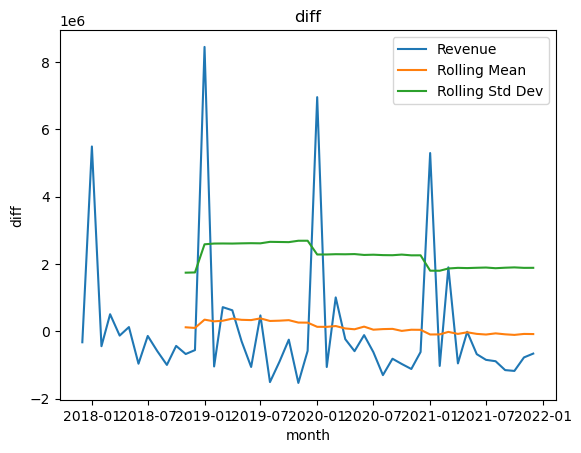

In [51]:
print(test_stationaity(monthly_revenue.dropna(), 'diff'))

Fluctuations in revenu appear more stable compared to the original data, indicating improved stationarity. The rolling mean and rolling standard deviation is nearly flat, confirming its stable over time. 

However, According to the ADF test The differencing operation did not make the series stationary. The ADF statistic is significantly greater (less negative) than all critical values (1%, 5%, 10% levels). This indicates that the null hypothesis of non-stationarity cannot be rejected. The p-value is greater than 0.05, meaning there is insufficient evidence to reject the null hypothesis of non-stationarity.

This could be due to Remaining Trends and potemtial seasonilty in the data. Next i''l apply Apply Seasonal Differencing and other options and test each one to see which one has the best and maek its stationary. 

In [53]:
monthly_revenue['diff_seasonal'] = monthly_revenue['revenue'] - monthly_revenue['revenue'].shift(12) #seasonality
monthly_revenue['diff_combined'] = monthly_revenue['diff_seasonal'] - monthly_revenue['diff_seasonal'].shift()

monthly_revenue['log_revenue'] = np.log(monthly_revenue['revenue'])
monthly_revenue['log_diff'] = monthly_revenue['log_revenue'] - monthly_revenue['log_revenue'].shift()
monthly_revenue.head()

,revenue,rolling_mean,rolling_std,diff,diff_seasonal,diff_combined,log_revenue,log_diff
month,,,,,,,,
2017-01-01,3796100,NaN,NaN,NaN,NaN,NaN,15.149485,NaN
2017-02-01,3554150,NaN,NaN,-241950.0,NaN,NaN,15.083626,-0.065858
2017-03-01,4017700,NaN,NaN,463550.0,NaN,NaN,15.206220,0.122594
2017-04-01,3633750,NaN,NaN,-383950.0,NaN,NaN,15.105776,-0.100444
2017-05-01,3722150,NaN,NaN,88400.0,NaN,NaN,15.129812,0.024036


ADF Statistic: -0.8303454976550522,
P-value: 0.8100454156047566
1% -3.5925042342183704
5% -2.931549768951162
10% -2.60406594375338
None


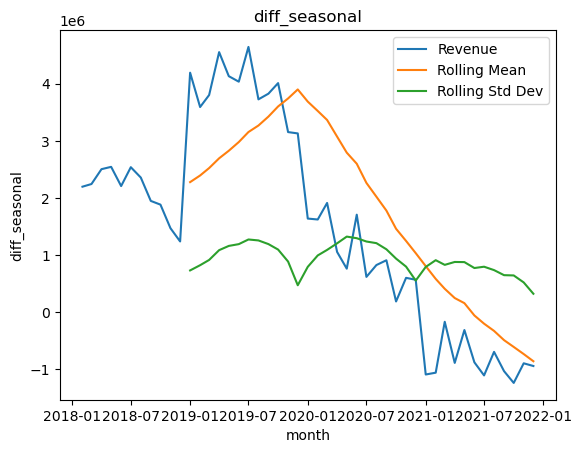

In [54]:
print(test_stationaity(monthly_revenue.dropna(), 'diff_seasonal'))

**Non-stationariy**. Seasonal differencing alone did not make the series stationary

ADF Statistic: -3.12308842255655,
P-value: 0.024891058027664142
1% -3.5885733964124715
5% -2.929885661157025
10% -2.6031845661157025
None


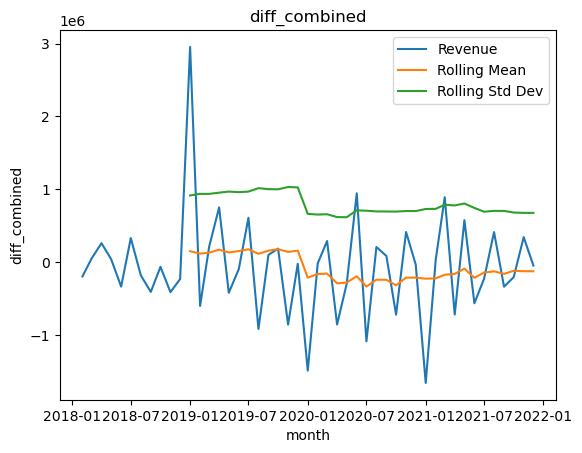

In [56]:
print(test_stationaity(monthly_revenue.dropna(), 'diff_combined'))

**Weak stationay**. The p-value (0.0259) is below 0.05, indicating the series is weakly stationary. Combined differencing improved stationarity, but it is not strongly stationary. Further transformations needed

ADF Statistic: -5.736918313387455,
P-value: 6.406636641978645e-07
1% -3.626651907578875
5% -2.9459512825788754
10% -2.6116707716049383
None


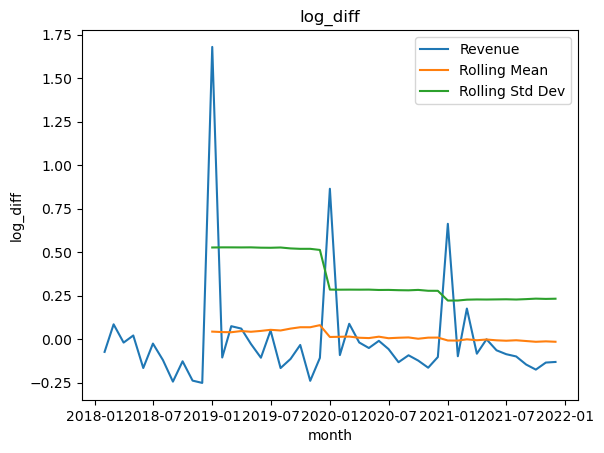

In [58]:
print(test_stationaity(monthly_revenue.dropna(), 'log_diff'))

**Strong stationaryity** Log transformation followed by differencing successfully made the series stationary. The ADF Statistic is much lower (more negative) than all critical values (1%, 5%, and 10%), indicating we reject the null hypothesis at all confidence levels.
The p-value is effectively 0, meaning the series is strongly stationary.

#### Modeling - ARIMA Model

In [61]:
# Splitting the data
train_size = int(len(monthly_revenue) * 0.8)
train, test = monthly_revenue[:train_size], monthly_revenue[train_size:]

In [62]:
monthly_revenue.head(3)

,revenue,rolling_mean,rolling_std,diff,diff_seasonal,diff_combined,log_revenue,log_diff
month,,,,,,,,
2017-01-01,3796100,NaN,NaN,NaN,NaN,NaN,15.149485,NaN
2017-02-01,3554150,NaN,NaN,-241950.0,NaN,NaN,15.083626,-0.065858
2017-03-01,4017700,NaN,NaN,463550.0,NaN,NaN,15.206220,0.122594


The value for d=1, because it was shifted by one. if original was stationary d=0. Lets plot the ACF and PACF to find the optimal q anf p values. 

first significant spike (outside shaded area) is at lag 12S, so q=12.
first significant spike (outside shaded area) is at lag 11 then 12, so p=11.


#### Finding ARIMA parameters manually 

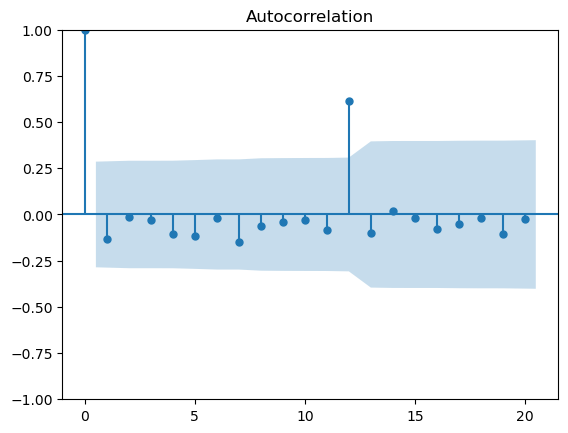

In [65]:
plot_acf(train['log_diff'].dropna(), lags=20)
plt.show()

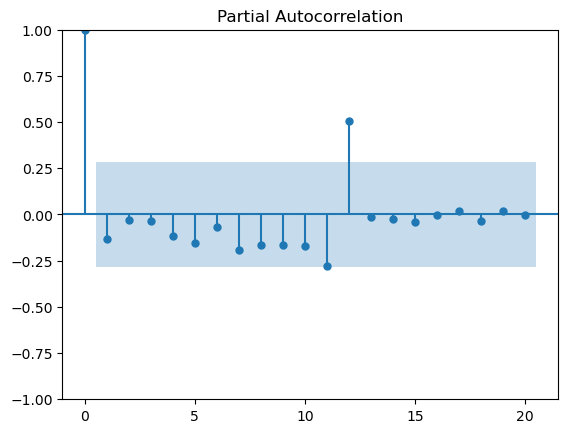

In [66]:
plot_pacf(train['log_diff'].dropna(), lags=20)
plt.show()

In [67]:
model = ARIMA(train['log_diff'].dropna(), order=(11, 1, 12))
ARIMA_model = model.fit()
# print(ARIMA_model.summary())

In [68]:
# auto_model = auto_arima(train['revenue'].dropna(),
#                         seasonal=True,   # include seasonality
#                         d=1,
#                         m=12,  # seasonal period
#                         trace=True,    
#                         error_action='ignore', 
#                         suppress_warnings=True)

# print(auto_model.summary()) #(p, d, q) 

### Modeling

In [70]:
# ARIMA Model

arima_model = ARIMA(train['revenue'].dropna(), order=(0, 1, 0))
arima_fit = arima_model.fit()

# print(results.summary())

In [71]:
# SARIMA Model

sarima_model = SARIMAX(train['revenue'], 
                       order=(0, 1, 0),  #(p, d, q)
                       seasonal_order=(0, 1, 0, 12))  # Adjust seasonal_order
sarima_fit = sarima_model.fit()
# print(sarima_fit.summary())

## Forecasting

2021-01-01    5634950.0
2021-02-01    5634950.0
2021-03-01    5634950.0
2021-04-01    5634950.0
2021-05-01    5634950.0
2021-06-01    5634950.0
2021-07-01    5634950.0
2021-08-01    5634950.0
2021-09-01    5634950.0
2021-10-01    5634950.0
2021-11-01    5634950.0
2021-12-01    5634950.0
Freq: MS, Name: predicted_mean, dtype: float64


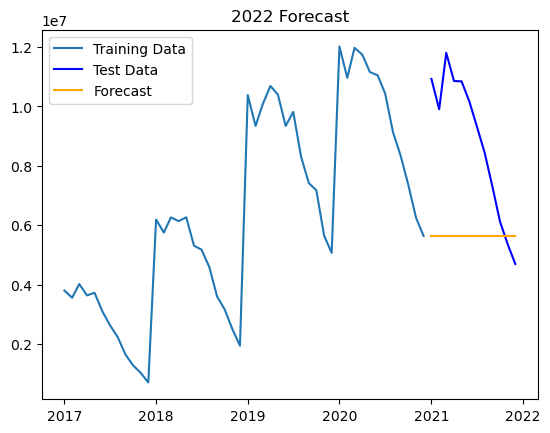

RMSE: 3925878.5894914125
2021-01-01    12590375.0
2021-02-01    11533900.0
2021-03-01    12544375.0
2021-04-01    12314650.0
2021-05-01    11728525.0
2021-06-01    11618550.0
2021-07-01    11003925.0
2021-08-01     9706650.0
2021-09-01     8895775.0
2021-10-01     7929125.0
2021-11-01     6813625.0
2021-12-01     6202525.0
Freq: MS, Name: predicted_mean, dtype: float64


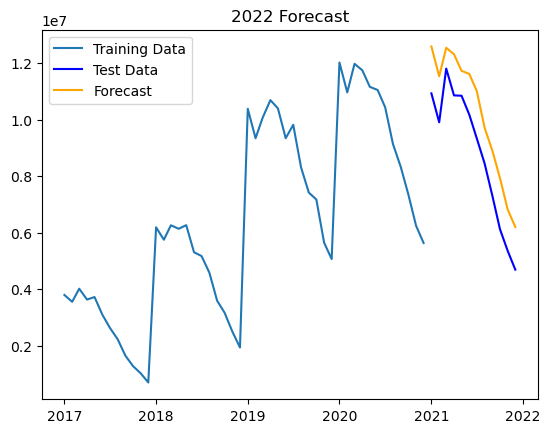

RMSE: 1460072.9716531578
2021-01-01    0.466361
2021-02-01   -0.057942
2021-03-01    0.086869
2021-04-01   -0.098790
2021-05-01   -0.040565
2021-06-01    0.027693
2021-07-01   -0.131818
2021-08-01   -0.074653
2021-09-01   -0.124582
2021-10-01   -0.186277
2021-11-01   -0.118738
2021-12-01   -0.130907
Freq: MS, Name: predicted_mean, dtype: float64


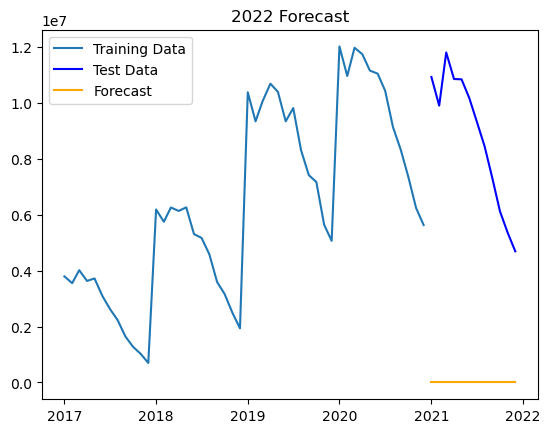

RMSE: 9109462.761355054


In [87]:
def forecast(column, models, train, test):
    for model in models:
        forecast = model.forecast(steps=len(test))  # Forecast next 12 months
        print(forecast)
        # Plot actual vs forecast
        plt.plot(train[column], label="Training Data")
        plt.plot(test[column], label="Test Data", color="blue")
        plt.plot(test.index, forecast, label="Forecast", color="orange")
        plt.title("2022 Forecast")
        plt.legend()
        plt.show()
        
        # Validation
        from sklearn.metrics import mean_squared_error
        rmse = np.sqrt(mean_squared_error(test[column], forecast))
        print(f"RMSE: {rmse}")

forecast('revenue', [arima_fit, sarima_fit, ARIMA_model], train, test)

As we can see here the SARIMA model performs the best for forecasting.  When the model is able to consider seasonlity trend it produces a better forecast. For the next steps i will focus on fine tuning the paramters of the SARIMA model. 

## Optimize Parameters: 
### Automated Approach with Auto-ARIMA

This function automatically finds the best p, d, and q values. I'll compare the results with the values i found. Lower AIC and BIC values indicate better models.Use Auto-SARIMA to find the best combination of (p, d, q) 

                                     SARIMAX Results                                      
Dep. Variable:                            revenue   No. Observations:                   48
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -520.434
Date:                            Sun, 22 Dec 2024   AIC                           1050.867
Time:                                    18:12:14   BIC                           1058.644
Sample:                                01-01-2017   HQIC                          1053.552
                                     - 12-01-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1453      1.922     -0.076      0.940      -3.913       3.622
ma.L1         -0.1481      1.811   

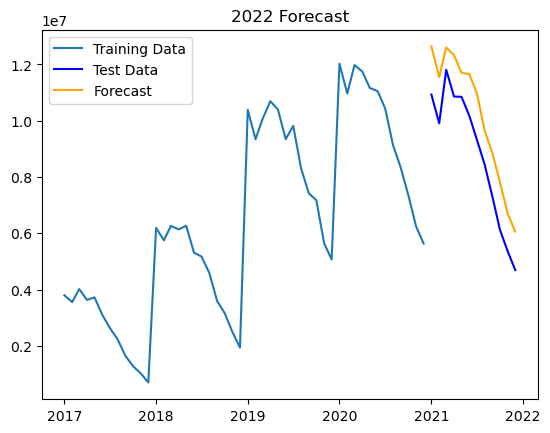

RMSE: 1425630.0047069783


In [90]:
def fine_tune_parameters(column, train, test, order):
    # Fitting SARIMA Model on train
    sarima_model = SARIMAX(train[column], 
                       order= order,  #(p, d, q)
                       seasonal_order= order + (12,))  
    sarima_fit = sarima_model.fit()
    print(sarima_fit.summary())

    # Forecasting on test
    forecast = sarima_fit.forecast(steps=len(test))  #Forecast next 12 months
    print(forecast)

    # Plot actual vs forecast
    plt.plot(train[column], label="Training Data")
    plt.plot(test[column], label="Test Data", color="blue")
    plt.plot(test.index, forecast, label="Forecast", color="orange")
    plt.title('2022 Forecast')
    plt.legend()
    plt.show()

    # Validation
    from sklearn.metrics import mean_squared_error
    rmse = np.sqrt(mean_squared_error(test[column], forecast))
    print(f"RMSE: {rmse}")
    

fine_tune_parameters('revenue', train, test, (1,1,1))

                                     SARIMAX Results                                      
Dep. Variable:                            revenue   No. Observations:                   48
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -523.115
Date:                            Sun, 22 Dec 2024   AIC                           1048.230
Time:                                    18:12:20   BIC                           1049.786
Sample:                                01-01-2017   HQIC                          1048.767
                                     - 12-01-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      3.875e+11   3.42e+10     11.331      0.000     3.2e+11    4.55e+11
Ljung-Box (L1) (Q):                

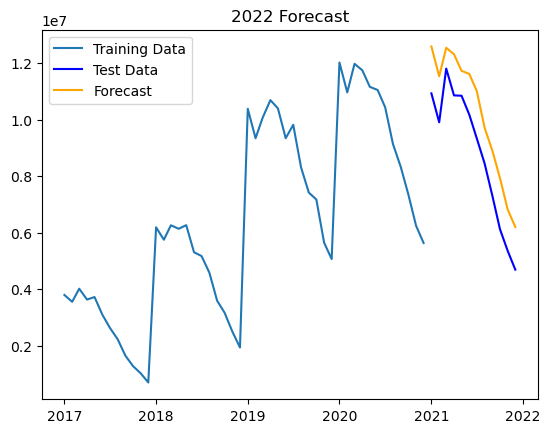

RMSE: 1460072.9716531578


In [92]:
fine_tune_parameters('revenue', train, test, (0,1,0))

                                     SARIMAX Results                                      
Dep. Variable:                            revenue   No. Observations:                   48
Model:             SARIMAX(2, 1, 2)x(2, 1, 2, 12)   Log Likelihood                -512.228
Date:                            Sun, 22 Dec 2024   AIC                           1042.455
Time:                                    18:12:28   BIC                           1056.453
Sample:                                01-01-2017   HQIC                          1047.287
                                     - 12-01-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3005      0.126    -10.344      0.000      -1.547      -1.054
ar.L2         -0.9958      0.106   

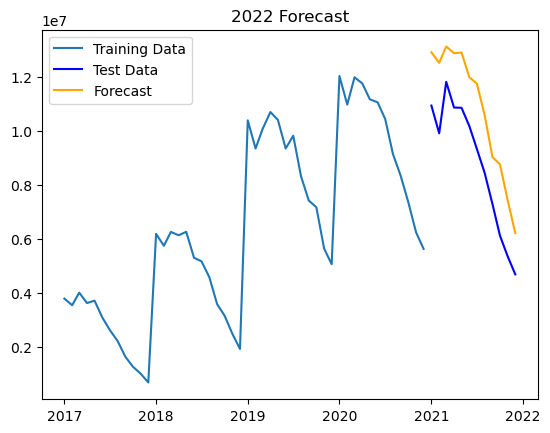

RMSE: 2055800.216465426


In [94]:
fine_tune_parameters('revenue', train, test, (2,1,2))

In [78]:
1425630 #lowest rmse 1,1,1 
1460072 #0,1,0
2055800 #2,1,2

2055800

Let's try on the log_diff column which is the data we made stationary. The we can convert it back to its orginal form for interpretability. 

In [112]:
sarima_log_model = SARIMAX(train['log_diff'].dropna(),
                       order=(1, 1, 1),  # Replace with optimized p, d, q
                       seasonal_order=(1, 1, 1, 12))  # Seasonal components
sarima_log_fit = sarima_log_model.fit()
# print(sarima_log_fit.summary())

2021-01-01    0.068213
2021-02-01   -0.086979
2021-03-01    0.077348
2021-04-01   -0.202509
2021-05-01   -0.074612
2021-06-01    0.050842
2021-07-01   -0.255854
2021-08-01   -0.064908
2021-09-01   -0.182918
2021-10-01   -0.317961
2021-11-01   -0.092751
2021-12-01   -0.206734
Freq: MS, Name: predicted_mean, dtype: float64


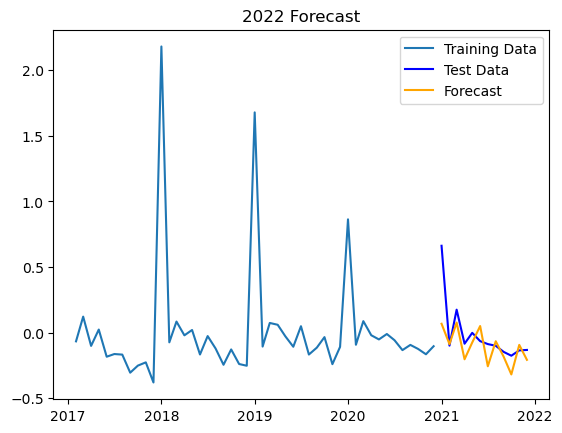

RMSE: 0.19469278024636552


In [110]:
forecast('log_diff', [sarima_log_fit], train, test)

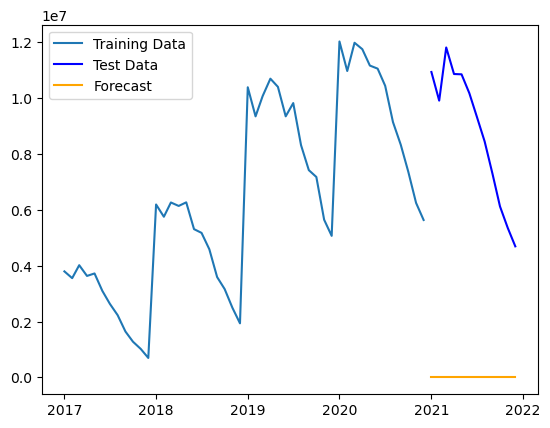

In [139]:
forecast_diff = sarima_log_fit.forecast(steps=len(test))

# Reverse the differencing
forecast_log = forecast_diff.cumsum() + train['log_diff'].iloc[-1]
forecast_revenue = np.exp(forecast_log)

plt.plot(train['revenue'], label="Training Data")
plt.plot(test['revenue'], label="Test Data", color="blue")
plt.plot(test.index, forecast_revenue, label="Forecast", color="orange")
plt.legend()
plt.show()

                                     SARIMAX Results                                      
Dep. Variable:                           log_diff   No. Observations:                   48
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                  14.603
Date:                            Sun, 22 Dec 2024   AIC                            -19.205
Time:                                    18:13:28   BIC                            -11.428
Sample:                                01-01-2017   HQIC                           -16.521
                                     - 12-01-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3074      0.291     -1.055      0.291      -0.878       0.263
ma.L1         -0.9375      0.141   

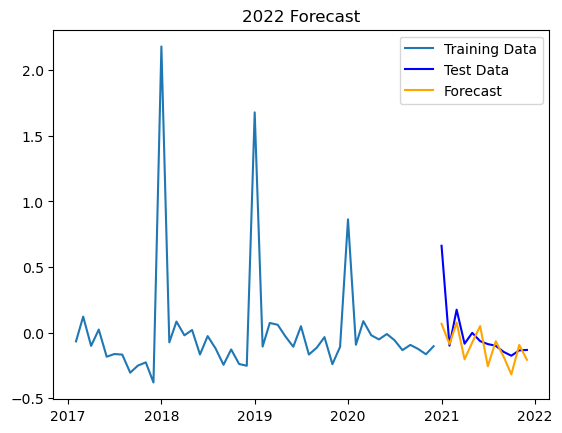

RMSE: 0.1946651516756609


In [96]:
fine_tune_parameters('log_diff', train, test, (1,1,1))

### Residual Analysis

In [82]:
# Test for stationarity of residuals
residuals_df = pd.DataFrame(residuals, columns = ['residuals'])
print(test_stationaity(residuals_df, 'residuals'))

NameError: name 'residuals' is not defined

In [ ]:
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(test['revenue'], forecast))
print(f"RMSE: {rmse}")

In [ ]:
# Restore warnings 
warnings.filterwarnings("default")